# Regional Analysis of Chips Sales and Customer Behavior
__Analyst: Albert Dellor__

__Table of Contents__

<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#EDA">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Strategy & Conclusions</a></li>
</ul>


# __Introduction__
<a id="intro"></a>
This project aims at analyzing the purchasing behavior of customers who buy chips, which includes identifying the frequency, quantity, and types of chips they purchase in an effort to inform and drive strategy for supermarket's chips division for the next half year. 

## __Data description__


# __Data Wrangling__
<a id="Wrangling"></a>

__Import all packages and set plots to be embedded inline__

In [1783]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import requests
from IPython.display import Image
from wordcloud import WordCloud
from collections import Counter
import matplotlib.dates as dates
%matplotlib inline
from scipy.signal import find_peaks
from scipy.stats import ttest_ind

__Loading the dataset: Get the URL of dataset. Create request, download transaction and purchase behaviour datasets__

In [10]:
urls = ['https://cdn.theforage.com/vinternships/companyassets/32A6DqtsbF7LbKdcq/QVI_transaction_data.xlsx',
        'https://cdn.theforage.com/vinternships/companyassets/32A6DqtsbF7LbKdcq/QVI_purchase_behaviour.csv']

for url in urls:
    data = requests.get(url)
    with open(url.split('/')[-1], mode = 'wb') as file:
        file.write(data.content)


 __Loading Datasets__

In [1726]:
transactions = pd.read_excel('QVI_transaction_data.xlsx')
purchase_behavor = pd.read_csv('QVI_purchase_behaviour.csv')

## __Data Assessment__
__Visual assessment and programmatic assessments were conducted to detect quality and tidiness issues with both dataset__

 - Visual assessment of data in Microsoft excell
 - Programmatic assessment in python

### __Assessment: QVI_purchase_behaviour.csv__

In [1727]:
purchase_behavor.sample(5)

,LYLTY_CARD_NBR,LIFESTAGE,PREMIUM_CUSTOMER
21630,79075,OLDER SINGLES/COUPLES,Mainstream
24918,90169,YOUNG SINGLES/COUPLES,Premium
38566,144102,MIDAGE SINGLES/COUPLES,Premium
23859,87064,YOUNG SINGLES/COUPLES,Budget
50392,188237,MIDAGE SINGLES/COUPLES,Mainstream


__Dimensions of data set__

In [1728]:
print('Rows: {}\nColumns: {}'.format(purchase_behavor.shape[0]\
                                     ,purchase_behavor.shape[1]))

Rows: 72637
Columns: 3


__Missing values and data types__

In [1730]:
purchase_behavor.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72637 entries, 0 to 72636
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   LYLTY_CARD_NBR    72637 non-null  int64 
 1   LIFESTAGE         72637 non-null  object
 2   PREMIUM_CUSTOMER  72637 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.7+ MB


__Number of unique values in PREMIUM_CUSTOMER and LIFESTAGE__

In [1731]:
purchase_behavor.PREMIUM_CUSTOMER.nunique(),\
purchase_behavor.LIFESTAGE.nunique()

(3, 7)

### __NB__:
The data consists of __72637 rows__ by __3 columns__. There are __no missing vaules__. However, __PREMIUM_CUSTOMER__ and __LIFESTAGE__ columns have few number of unique values, thus can be converted from string object to categorical date type as they hold no ordinal value.

### __Assessment: QVI_transaction_data.xlsx__

In [1732]:
transactions.sample(5)

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES
155586,43404,62,62199,58968,76,Woolworths Medium Salsa 300g,2,3.0
200596,43398,219,219182,219066,1,Smiths Crinkle Cut Chips Barbecue 170g,2,5.8
47374,43423,170,170013,171682,14,Smiths Crnkle Chip Orgnl Big Bag 380g,2,11.8
162703,43634,154,154138,154034,51,Doritos Mexicana 170g,2,8.8
58845,43580,67,67015,63917,31,Infzns Crn Crnchers Tangy Gcamole 110g,2,7.6


__Dimensions of data set__

In [1733]:
print('Rows: {}\nColumns: {}'.format(transactions.shape[0],\
                                     transactions.shape[1]))

Rows: 264836
Columns: 8


__Missing values and data types__

In [1734]:
transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264836 entries, 0 to 264835
Data columns (total 8 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   DATE            264836 non-null  int64  
 1   STORE_NBR       264836 non-null  int64  
 2   LYLTY_CARD_NBR  264836 non-null  int64  
 3   TXN_ID          264836 non-null  int64  
 4   PROD_NBR        264836 non-null  int64  
 5   PROD_NAME       264836 non-null  object 
 6   PROD_QTY        264836 non-null  int64  
 7   TOT_SALES       264836 non-null  float64
dtypes: float64(1), int64(6), object(1)
memory usage: 16.2+ MB


__Descriptive statistics__

In [1735]:
transactions.describe()[['PROD_QTY','TOT_SALES']]

,PROD_QTY,TOT_SALES
count,264836.000000,264836.000000
mean,1.907309,7.304200
std,0.643654,3.083226
min,1.000000,1.500000
25%,2.000000,5.400000
50%,2.000000,7.400000
75%,2.000000,9.200000
max,200.000000,650.000000


__check for duplicates.__
__The only unique identifier in dataset is TXN_ID (transaction id).__
__Thus is used to find duplicates__

In [1736]:
transactions[transactions.duplicated()]

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES
124845,43374,107,107024,108462,45,Smiths Thinly Cut Roast Chicken 175g,2,6.0


__Further investigate the transaction ID__

In [1737]:
transactions.query("TXN_ID == 108462")[['TXN_ID','PROD_NAME','PROD_QTY','TOT_SALES']]

,TXN_ID,PROD_NAME,PROD_QTY,TOT_SALES
124843,108462,Smiths Thinly Cut Roast Chicken 175g,2,6.0
124844,108462,Cheetos Chs & Bacon Balls 190g,2,6.6
124845,108462,Smiths Thinly Cut Roast Chicken 175g,2,6.0


### __NB__
There are __no missing data__. __PROD_QTY and TOT_SALES have 75% of entire data being under 2 and 9.2 respectively__, however the maximun values are 200 and 650 respectively, there might be outliers present. Further investigation reveal that there was double recording of a transaction involving __Smiths Thinly Cut Roast Chicken 175g__

### __Summary of assessment__

Transaction data (unclean)

__Tidiness issues__
 1. Product name contains product mass variable as well, thus must be separated into respective columns as each variable must form exclusive column to comply with data tidiness standards.
 
 2. Presence of duplicate transaction involving Smiths Thinly Cut Roast Chicken 175g. All entries must be unique. Thus duplicates are dropped.
 
 3. Absence of unit cost column.
 
 
__Quality issues__

 4. PROD_QTY and TOT_SALES may have outliers.
 
 5. product name has inconsistent spacing thus must be formated to comply with data quality standards.
 
 6. Product name may contain irrelevant products other than chips.
 
 7. date format is in Excel serial number instead of pandas datetime object.
 
 8. convert `PREMIUM_CUSTOMER` and `LIFESTAGE` columns to categorical data type.
 
Purchase behavior data(clean) 

## __Data Cleaning__
In this sectionall the data issues outlined in assesment stage are cleaned

In [1738]:
# make copies of both data sets
purchase_behavor_copy = purchase_behavor.copy()
transactions_copy = transactions.copy()

#### Issue #1: separate product mass and product name into deparate columns

In [1739]:
regex = r'(\d+)(g|G)'
transactions_copy['PACK_SIZE'] = pd.to_numeric(
                                    transactions_copy.PROD_NAME\
                                    .str.extract(regex)[0])


#### Issue #2: Remove duplicates in data set

In [1740]:
transactions_copy.drop_duplicates(inplace = True)

#### Issue #3: Add a unit cost column

In [1741]:
transactions_copy['UNIT_COST'] = np.divide(transactions_copy.TOT_SALES,transactions_copy.PROD_QTY)


#### Issue #7: Format date from Excel serial number to  pandas datetime object

In [1742]:
transactions_copy.DATE = pd.to_datetime(transactions_copy.DATE, unit='d',\
                         origin=pd.Timestamp('1899-12-30'))

#### Issue #4: PROD_QTY and TOT_SALES may have outliers

In [1743]:
transactions_copy.nlargest(6,'TOT_SALES')[['PROD_NAME','PROD_QTY','TOT_SALES']]

,PROD_NAME,PROD_QTY,TOT_SALES
69762,Dorito Corn Chp Supreme 380g,200,650.0
69763,Dorito Corn Chp Supreme 380g,200,650.0
5179,Smiths Crnkle Chip Orgnl Big Bag 380g,5,29.5
55558,Smiths Crnkle Chip Orgnl Big Bag 380g,5,29.5
69496,Smiths Crnkle Chip Orgnl Big Bag 380g,5,29.5
117850,Smiths Crnkle Chip Orgnl Big Bag 380g,5,29.5


looking at the 6 largest TOT_SALES, its evident that 650 are outliers.
To further comfirm this, it is general accepted that any data point that falls outside the range of Q1 - 1.5 x IQR to Q3 + 1.5 x IQR is considered a potential outlier

In [1744]:
stats = transactions_copy.describe()

In [1745]:
def outlier(column):
    Q1 = stats.loc['25%'][column]
    Q3 = stats.loc['75%'][column]
    IQR = Q3 - Q1
    low_range = Q1 - (1.5 * IQR)
    upper_range = Q3 + (1.5 * IQR)
    print("For {} an outlier is any value outside the range of {:.2f} and {:.2f}".\
    format(column,low_range,upper_range))

In [1746]:
outlier('PROD_QTY')
outlier('TOT_SALES')

For PROD_QTY an outlier is any value outside the range of 2.00 and 2.00
For TOT_SALES an outlier is any value outside the range of -0.30 and 14.90


In [1747]:
# Looking at the descriptive statistics of both data sets
pd.merge(pd.DataFrame(transactions_copy.PROD_QTY.describe()),\
         pd.DataFrame(transactions_copy.TOT_SALES.describe()),\
         on=pd.DataFrame(transactions_copy.TOT_SALES.describe()).index).rename(columns={'key_0':'index'})


,index,PROD_QTY,TOT_SALES
0,count,264835.000000,264835.000000
1,mean,1.907308,7.304205
2,std,0.643655,3.083231
3,min,1.000000,1.500000
4,25%,2.000000,5.400000
5,50%,2.000000,7.400000
6,75%,2.000000,9.200000
7,max,200.000000,650.000000


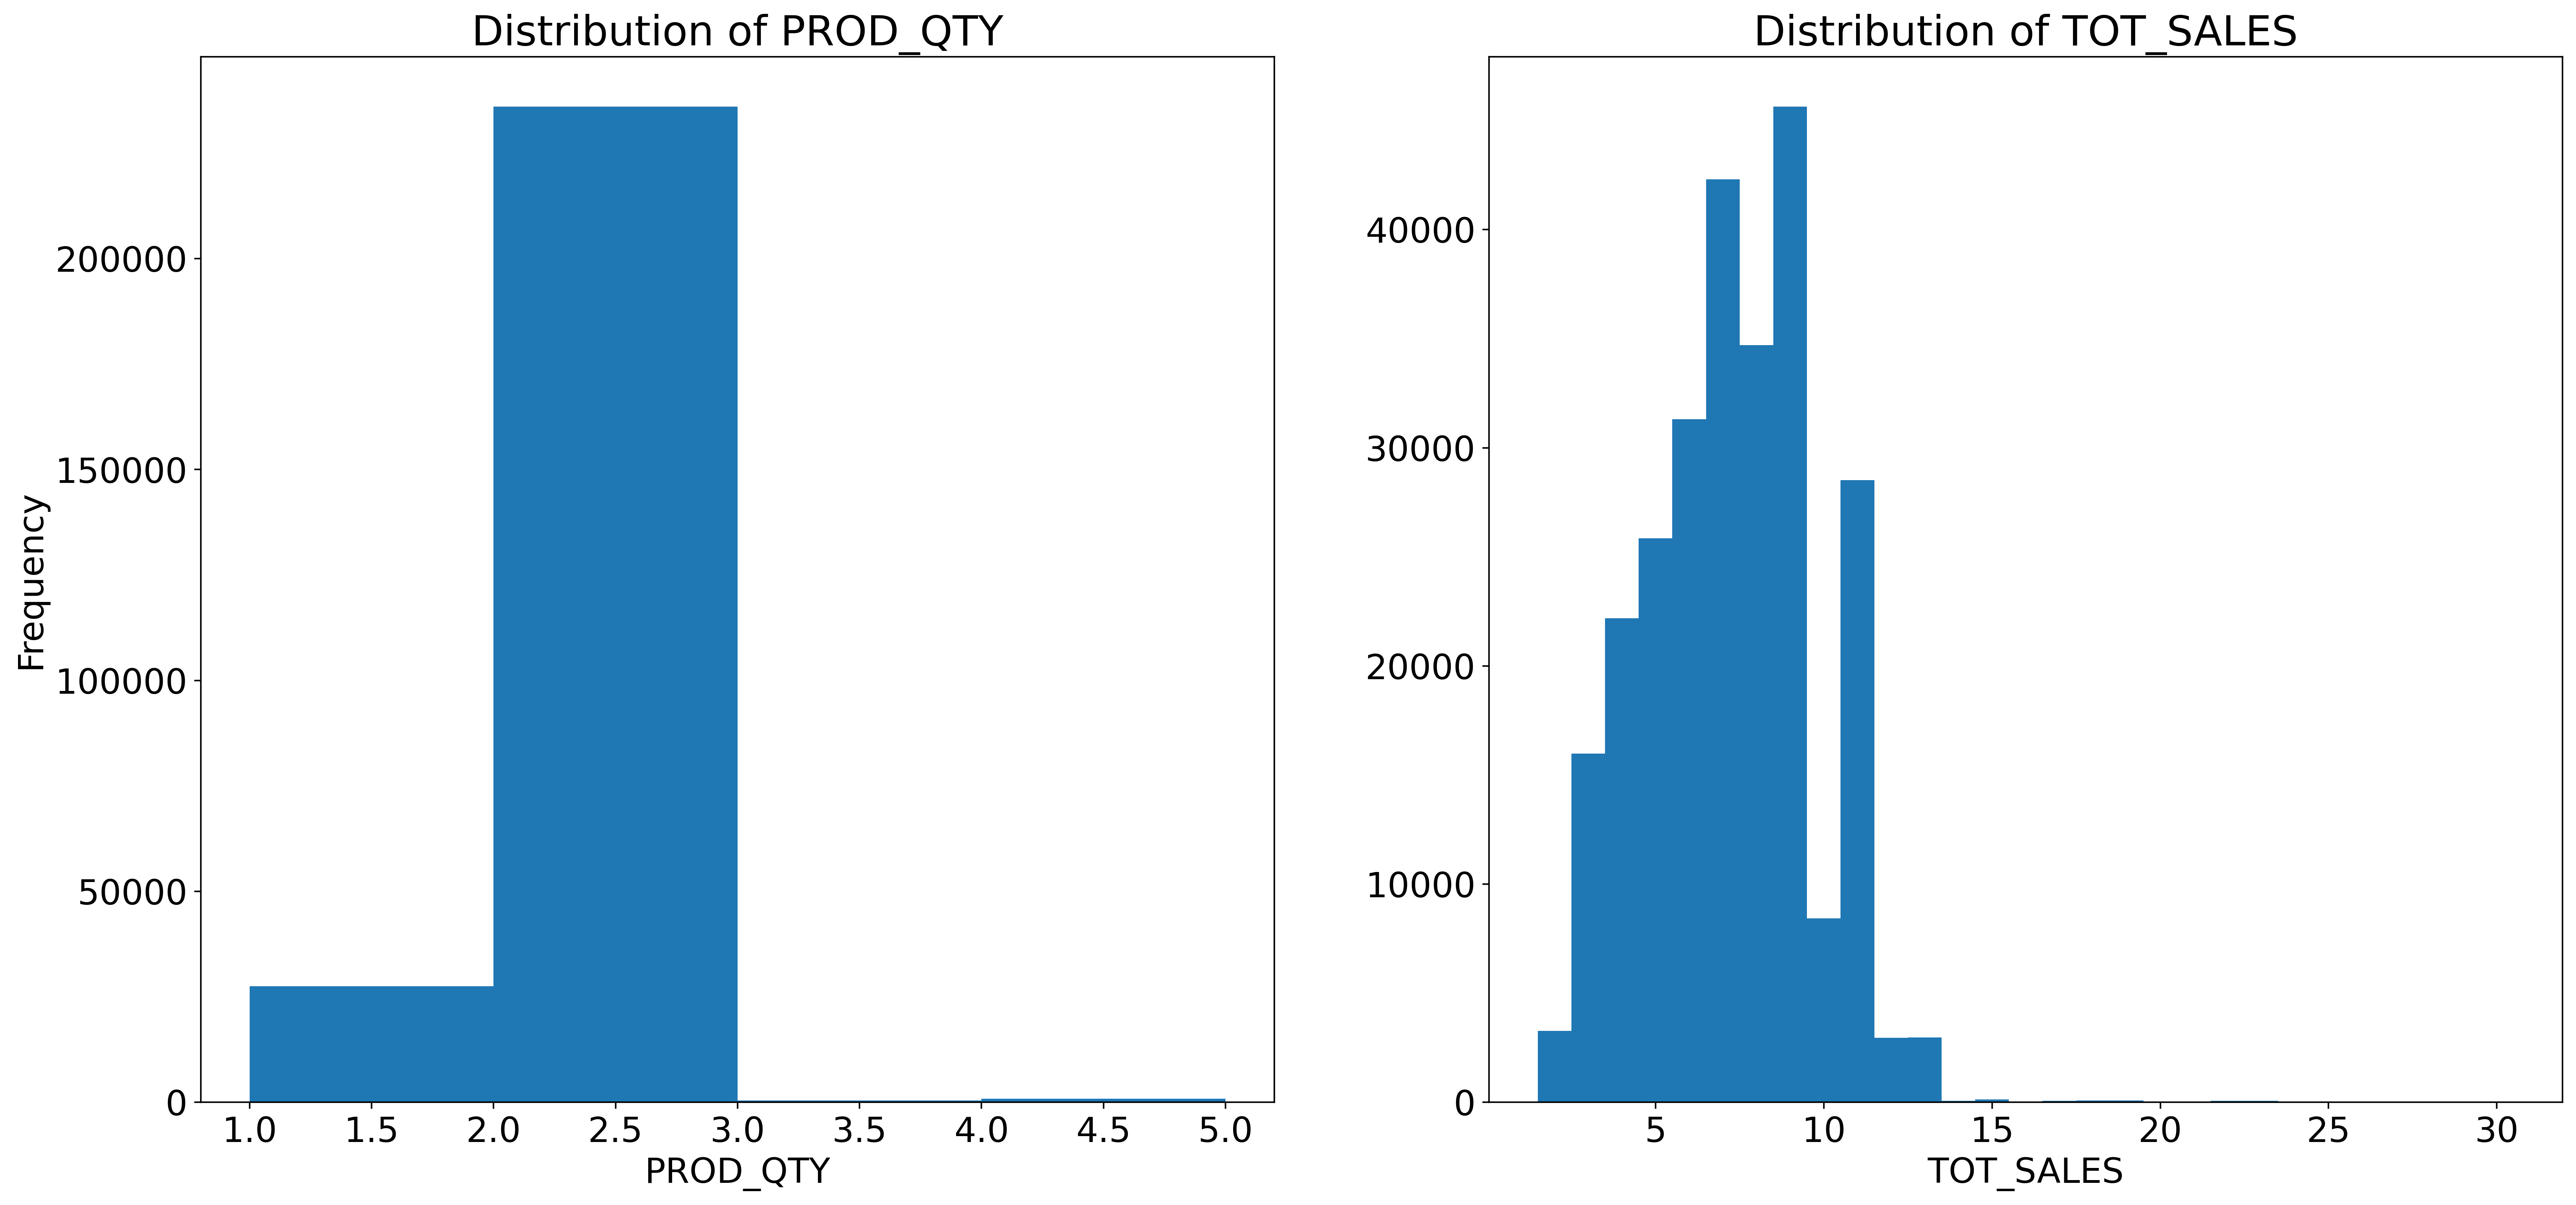

In [1748]:
plt.figure(figsize=(22,10),dpi=400)
plt.rcParams['font.size'] = 18
plt.subplot(1,2,1)
bin = np.arange(1,5+1,1);
plt.hist(transactions_copy.PROD_QTY,bins=bin);
plt.xlabel('PROD_QTY');
plt.ylabel('Frequency');
plt.title('Distribution of PROD_QTY');

plt.subplot(1,2,2)
bin = np.arange(1.5, 30+1.5,1);
plt.hist(transactions_copy.TOT_SALES, bins=bin);
plt.xlabel('TOT_SALES');
plt.title('Distribution of TOT_SALES');

It is evident that a customer with loyalty card number 226000, purchased large orders on two occasions in 2018 and 2019, thus creating the outliers for PROD_QTY and corresponding TOT_SALES .

Additionally, the histograms clearly show that a majority of the data is located between 1 to 3 for PROD_QTY and 1 to 15 for TOT_SALES.

Therefore is is safe to say that 200 and 650 for PROD_QTY and TOT_SALES are outliers respectively and are removed from the datase

__Outlier is droped from data set__

In [1749]:
index = transactions_copy.query("TOT_SALES == 650").index.values
transactions_copy.drop(index,axis=0, inplace=True)

#### Issue 5: format spacing in product name

In [1750]:
transactions_copy['PROD_NAME'] = transactions_copy.PROD_NAME\
                                    .str.replace(regex, '')\
                                    .str.replace(r'\s\s+', ' ',regex=True)\
                                    .str.replace('&', ' & ',regex=True)

/var/folders/jw/bf_46b5j2jdc8rkkcynkcqdr0000gn/T/ipykernel_3852/4169270361.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  transactions_copy['PROD_NAME'] = transactions_copy.PROD_NAME\


#### Issue 6: examine products summary,rid it of irrelevant products

In [1751]:
def wordcloud(data):
    wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                min_font_size = 10).generate_from_frequencies(data)
    plt.figure(figsize = (8, 8), facecolor = None) 
    plt.imshow(wordcloud) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
    plt.show()

##### __Summary of individual PROD_NAME words with wordcloud__

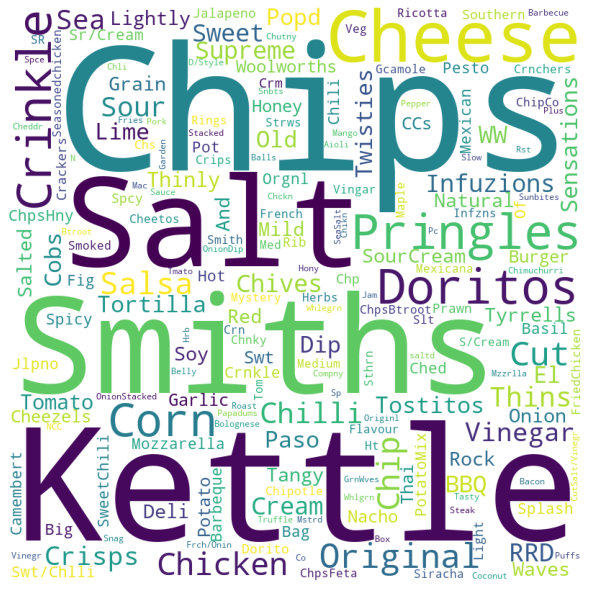

In [1752]:
PROD_NAME = transactions_copy.PROD_NAME.str.replace("&","")
words = ' '.join(PROD_NAME.values).split()
data = Counter(words)
wordcloud(data)

Taking a quick glance reveal that column generally contains chips products. However presence of some questionable words like __Salsa, salt, Mexican, Rock, Sea__ raises doubts and may indicate that not all are chips.
Next entire PROD_NAMEs are summarised to get better sense of products

__# Summary of entire  PROD_NAME products in wordcloud__

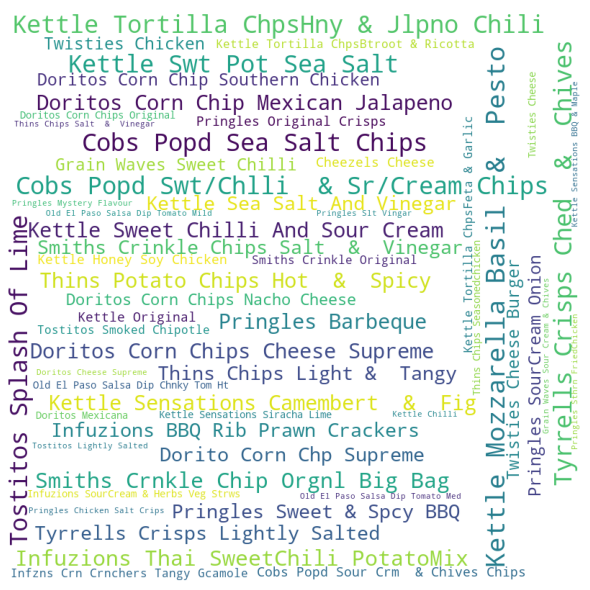

In [1753]:
products = transactions_copy.PROD_NAME.value_counts().to_dict()
wordcloud(products)

It turns out that previously alarming words like __Sea, salt, Mexican, Rock etc.__ are actually part of chips product name or branding. With the exception of __salsa__ as it is clearly doesn't qualify as chips and must be removed from column.

__Identify all salsa entries__

In [1754]:
salsa_df = transactions_copy[transactions_copy.PROD_NAME.\
                             str.contains('Salsa', case=False)]
total = salsa_df.PROD_NAME.value_counts().values.sum()
print('There are {} instances of irrelevant salsa products\
in dataset.\n'.format(total))
pd.DataFrame(salsa_df.PROD_NAME.value_counts()).reset_index().\
                            rename(columns={'index':'Product','PROD_NAME':'Counts'})

There are 18094 instances of irrelevant salsa productsin dataset.



,Product,Counts
0,Old El Paso Salsa Dip Chnky Tom Ht,3125
1,Old El Paso Salsa Dip Tomato Med,3114
2,Old El Paso Salsa Dip Tomato Mild,3085
3,Woolworths Mild Salsa,1491
4,Doritos Salsa Mild,1472
5,Smiths Crinkle Cut Tomato Salsa,1470
6,Red Rock Deli SR Salsa & Mzzrlla,1458
7,Doritos Salsa Medium,1449
8,Woolworths Medium Salsa,1430


In [1755]:
salsa_index = salsa_df.index.tolist()
transactions_copy.drop(index=salsa_index, inplace=True)
print('After removing {} irrelevant sala entries,initial {} total\
                    entries reduced to {}'.\
                    format(total,transactions.shape[0],transactions_copy.shape[0]))

After removing 18094 irrelevant sala entries,initial 264836 total                    entries reduced to 246739


__Assessing the most frequent words in descending order__

In [1756]:
PROD_NAME = transactions_copy.PROD_NAME.str.replace("&","")
words = ' '.join(PROD_NAME.values).split()
word_counts = Counter(words)
sorted_words = sorted(word_counts.items(), key=lambda x: x[1], reverse=True)
for word, count in sorted_words:
    print(f'{word}: {count}')

Chips: 49770
Kettle: 41288
Salt: 27976
Cheese: 27890
Smiths: 27389
Pringles: 25102
Crinkle: 22490
Corn: 22061
Doritos: 22041
Original: 21560
Cut: 19283
Chip: 18645
Chicken: 18576
Chilli: 15390
Sea: 14145
Thins: 14075
Sour: 13882
Crisps: 12607
Vinegar: 12402
RRD: 11894
Sweet: 11060
Infuzions: 11057
Supreme: 10961
Chives: 10951
Cream: 10723
WW: 10320
Cobs: 9693
Popd: 9693
Tortilla: 9580
Tostitos: 9471
Twisties: 9454
BBQ: 9434
Sensations: 9429
Lime: 9347
Thinly: 7506
Tyrrells: 6442
And: 6373
Tangy: 6332
SourCream: 6296
Grain: 6272
Waves: 6272
Lightly: 6248
Salted: 6248
Soy: 6121
Onion: 6116
Natural: 6050
Thai: 4737
Burger: 4733
Swt: 4718
Honey: 4661
Nacho: 4658
Potato: 4647
Cheezels: 4603
Garlic: 4572
CCs: 4551
Red: 4427
Rock: 4427
Deli: 4427
Mozzarella: 3304
Basil: 3304
Pesto: 3304
ChpsHny: 3296
Jlpno: 3296
Chili: 3296
Swt/Chlli: 3269
Sr/Cream: 3269
Ched: 3268
Pot: 3257
Splash: 3252
Of: 3252
SweetChili: 3242
PotatoMix: 3242
Crnkle: 3233
Orgnl: 3233
Big: 3233
Bag: 3233
Hot: 3229
Spicy: 32

#### Issue #8: convert PREMIUM_CUSTOMER and LIFESTAGE columns to categorical data type

In [1757]:
purchase_behavor_copy.PREMIUM_CUSTOMER = purchase_behavor_copy.PREMIUM_CUSTOMER.astype('category')
purchase_behavor_copy.LIFESTAGE = purchase_behavor_copy.LIFESTAGE.astype('category')


In [1758]:
purchase_behavor_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72637 entries, 0 to 72636
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   LYLTY_CARD_NBR    72637 non-null  int64   
 1   LIFESTAGE         72637 non-null  category
 2   PREMIUM_CUSTOMER  72637 non-null  category
dtypes: category(2), int64(1)
memory usage: 709.9 KB


#### Finally merge two data sets together

In [1759]:
clean_data = pd.merge(transactions_copy, purchase_behavor_copy, left_on='LYLTY_CARD_NBR',\
                      right_on='LYLTY_CARD_NBR', how='left')
clean_data.shape

(246739, 12)

In [1760]:
clean_data.isnull().sum()

DATE                0
STORE_NBR           0
LYLTY_CARD_NBR      0
TXN_ID              0
PROD_NBR            0
PROD_NAME           0
PROD_QTY            0
TOT_SALES           0
PACK_SIZE           0
UNIT_COST           0
LIFESTAGE           0
PREMIUM_CUSTOMER    0
dtype: int64

#### Save clean dataset

In [1761]:
clean_data.to_csv('wrangled_data.csv',index=False)

## Exploratory Data Analysis
<a id="EDA"></a>

In [1762]:
df = pd.read_csv('wrangled_data.csv',parse_dates=['DATE'])

In [1763]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 246739 entries, 0 to 246738
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   DATE              246739 non-null  datetime64[ns]
 1   STORE_NBR         246739 non-null  int64         
 2   LYLTY_CARD_NBR    246739 non-null  int64         
 3   TXN_ID            246739 non-null  int64         
 4   PROD_NBR          246739 non-null  int64         
 5   PROD_NAME         246739 non-null  object        
 6   PROD_QTY          246739 non-null  int64         
 7   TOT_SALES         246739 non-null  float64       
 8   PACK_SIZE         246739 non-null  int64         
 9   UNIT_COST         246739 non-null  float64       
 10  LIFESTAGE         246739 non-null  object        
 11  PREMIUM_CUSTOMER  246739 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(6), object(3)
memory usage: 22.6+ MB


The mean weekly total transaction is 677.8543956043956


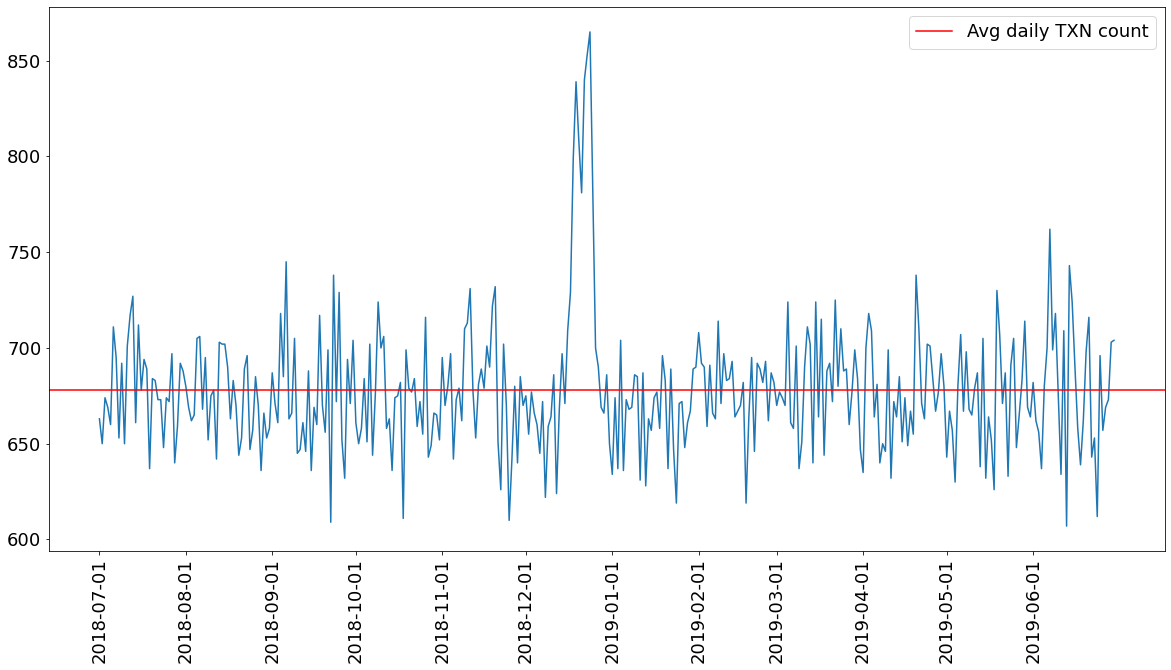

In [1764]:
date_txn = df.groupby('DATE')['TXN_ID'].count()
date = df.groupby(pd.Grouper(key='DATE', freq='MS'))['TXN_ID'].count()
avg_daily = date_txn.values.mean()
print('The mean weekly total transaction is {}'.format(avg_daily))

plt.figure(figsize=(20,10))
plt.plot(date_txn.index,date_txn.values);
plt.axhline(y= avg_daily, color = 'red', label = f'Avg daily TXN count');
plt.legend()
plt.xticks(rotation=90,ticks=date.index);

__Time series of total weekly transactions__

In [1765]:
date_TXN = df.groupby(pd.Grouper(key='DATE', freq='1W'))['TXN_ID'].count()
avg = date_TXN.values.mean()
print('The mean weekly total transaction is {}'.format(avg))
date= df.groupby(pd.Grouper(key='DATE', freq='MS'))['TXN_ID'].count()
xticks = date.index

The mean weekly total transaction is 4655.452830188679


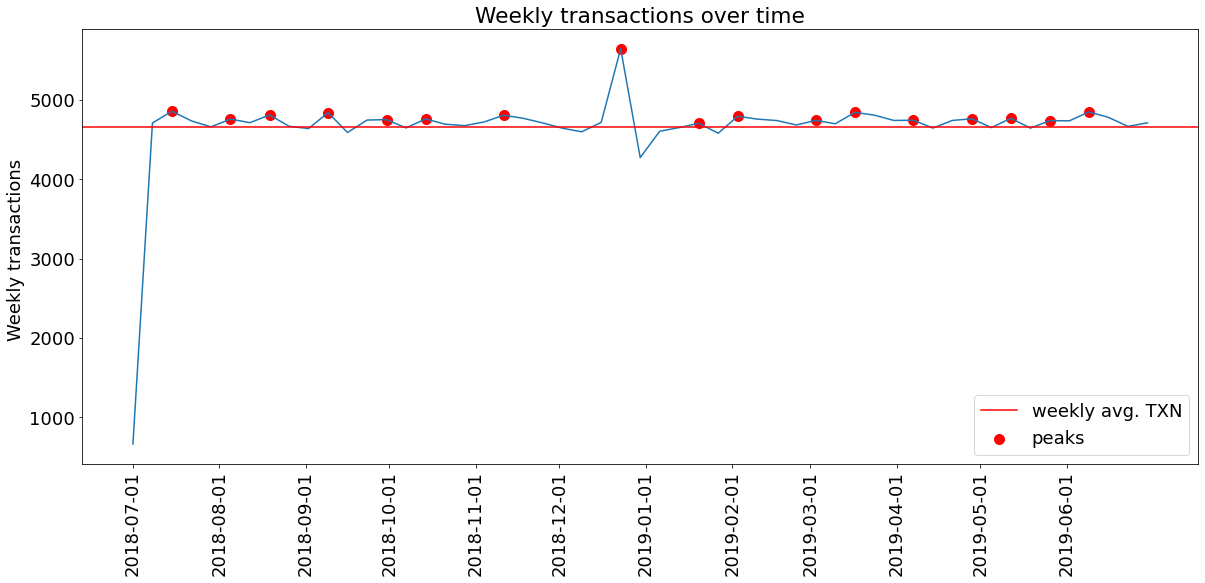

In [1766]:
plt.figure(figsize=(20,8))
plt.plot(date_TXN.index,date_TXN.values);
plt.xticks(rotation = 90);
plt.ylabel('Weekly transactions ');
plt.title('Weekly transactions over time');
plt.axhline(y= avg, color = 'red', label = 'weekly avg. TXN');
peaks, _ = find_peaks(date_TXN.values)
plt.scatter(date_TXN.index[peaks], date_TXN.values[peaks], color='red', s=100, label= 'peaks')
plt.xticks(xticks);
plt.legend(loc= 4);

The graph shows that weekly total transaction remain fairly stable around the mean of 4655 up until early december, which records a drastic increase in sales before crushing to below average in early January, and finally recovering in February. This customer purchase behavour is further investigated.

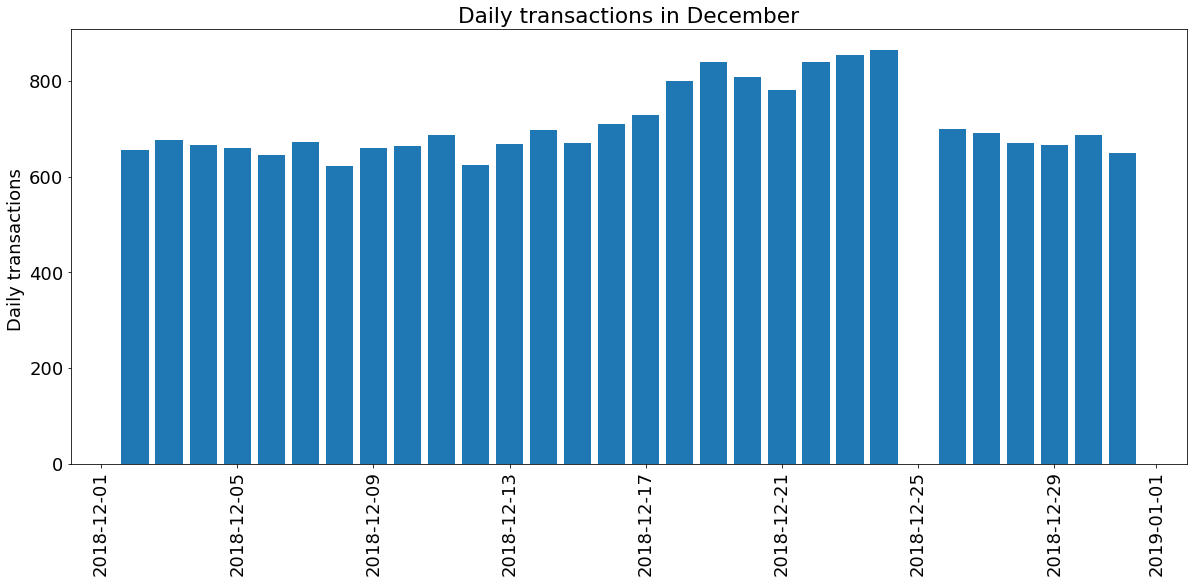

In [1767]:
plt.figure(figsize=(20,8))
christmas_TXN = df.query("DATE > '2018-12-01' & DATE < '2019-01-01'")
christmas_trend = christmas_TXN.groupby(pd.Grouper(key='DATE', freq='1D'))['TXN_ID'].count()
plt.bar(christmas_trend.index,christmas_trend.values);
plt.xticks(rotation=90);
plt.ylabel('Daily transactions ');
plt.title('Daily transactions in December');

A further look into the trend confirms that there daily transactions increase leading up tp the __25th__ (christmas day) before crashing to 0, as shops close for christmas. They then reopen on the 26th and trasactions recover steadily to average levels.

__pack size pack size__

In [1768]:
df.PACK_SIZE.describe()

count    246739.000000
mean        175.583523
std          59.432239
min          70.000000
25%         150.000000
50%         170.000000
75%         175.000000
max         380.000000
Name: PACK_SIZE, dtype: float64

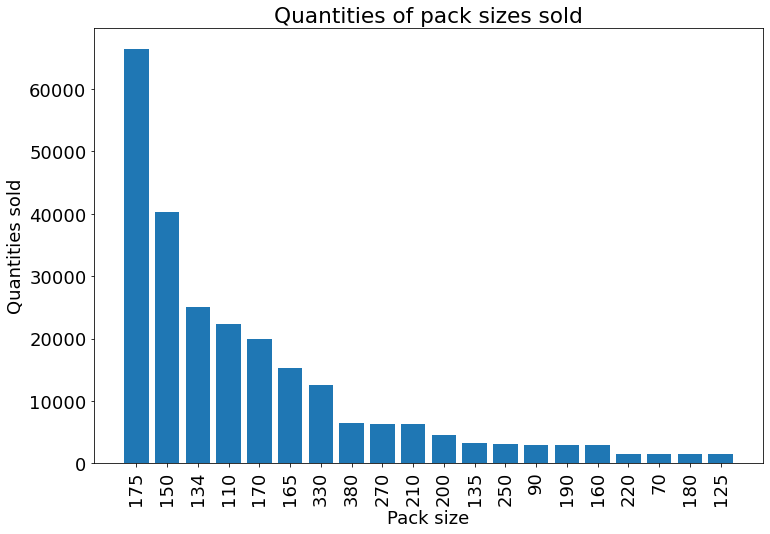

In [1769]:
color = sb.color_palette()[0]
plt.figure(figsize=(12,8))
pack_size = df.PACK_SIZE.value_counts()
pack_size
plt.bar(pack_size.index.astype(str),pack_size.values);
plt.xticks(rotation=90);
plt.ylabel('Quantities sold');
plt.xlabel('Pack size');
plt.title('Quantities of pack sizes sold');

The maximum pack size is 380g and minimum being 70g. However, the favorite among customers is size 175g, with it being the most sold all year.

__Create brand column and consilidate similar brands together__

In [1770]:
df['PROD_BRAND'] = pd.Series([x.split()[0] for x in df.PROD_NAME.values])


__RED and RRD, are both Red Rock Deli chips, thus are combined__

In [1771]:
df['PROD_BRAND'] = df['PROD_BRAND'].str.replace('Red|RRD','RRD Red',regex=True)


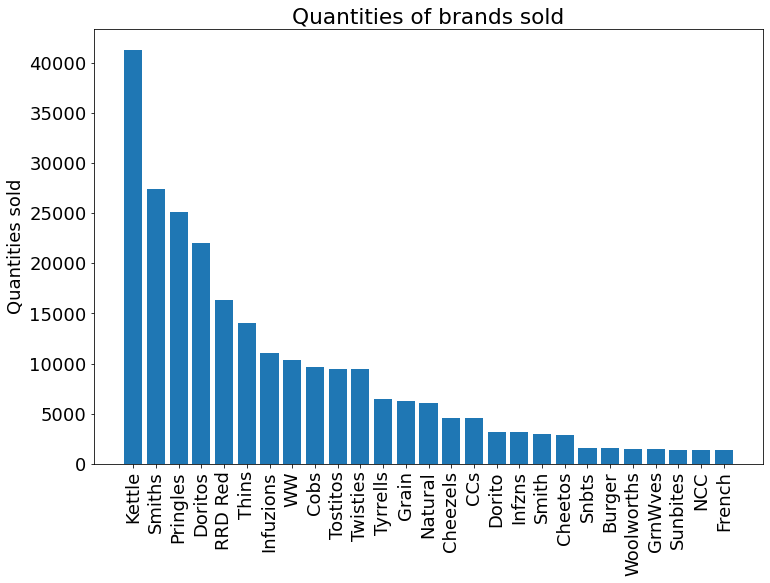

In [1772]:
plt.figure(figsize=(12,8))
brands = df['PROD_BRAND'].value_counts()
plt.bar(brands.index,brands.values);
plt.xticks(rotation=90);
plt.ylabel('Quantities sold');
plt.title('Quantities of brands sold');

Kettle, Smiths, Pringles and Doritos are the top 4 brands most prefered by customers as evident in the large numbers sold.

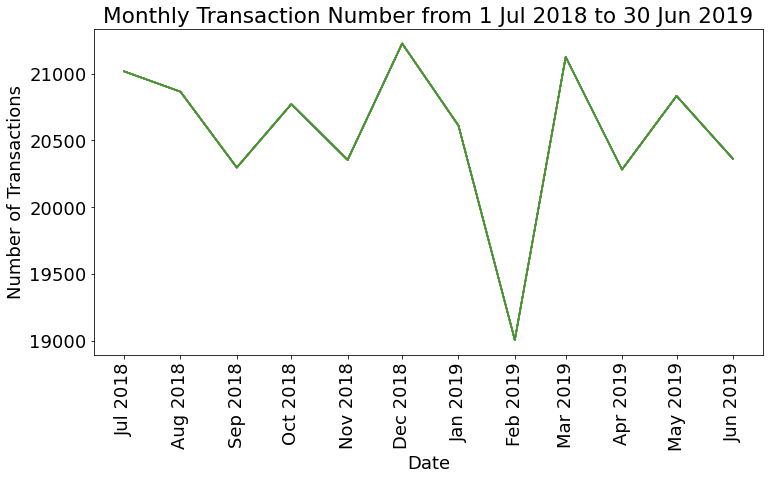

In [1773]:
# df.groupby('DATE')['TXN_ID'].count()

# df['Date'] = pd.to_datetime(df['DATE'])

# Group the data by month and count the number of transactions
date_txn = df.groupby(df['DATE'].dt.to_period('M')).count()

# Create the plot
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(date_txn.index.to_timestamp(), date_txn.values)

# Set xtick interval to one month
ax.xaxis.set_major_locator(dates.MonthLocator(interval=1))

# Set xtick labels format
ax.xaxis.set_major_formatter(dates.DateFormatter('%b %Y'))

# Set axis labels and title
ax.set_xlabel('Date')
ax.set_ylabel('Number of Transactions')
ax.set_title('Monthly Transaction Number from 1 Jul 2018 to 30 Jun 2019')
plt.xticks(rotation = 90);
# Show the plot
plt.show()

In [1774]:
df.head(3)

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_SIZE,UNIT_COST,LIFESTAGE,PREMIUM_CUSTOMER,PROD_BRAND
0,2018-10-17,1,1000,1,5,Natural Chip Compny SeaSalt,2,6.0,175,3.00,YOUNG SINGLES/COUPLES,Premium,Natural
1,2019-05-14,1,1307,348,66,CCs Nacho Cheese,3,6.3,175,2.10,MIDAGE SINGLES/COUPLES,Budget,CCs
2,2019-05-20,1,1343,383,61,Smiths Crinkle Cut Chips Chicken,2,2.9,170,1.45,MIDAGE SINGLES/COUPLES,Budget,Smiths


In [1775]:
# data = {
#     'product name': ['Potato chips', 'Cheese crackers', 'Corn chips', 'Tortilla chips', 'Apple', 'Banana', 'Rice cakes', 'Pita chips', 'Kettle chips', 'Popcorn'],
#     'crunchy index': [5, 8, 6, 9, 2, 1, 4, 7, 8, 3],
#     'spiciness level': [3, 7, 9, 5, 1, 2, 1, 3, 6, 1],
#     'cheese flavor': [True, True, False, False, False, False, False, False, True, False],
#     'sour cream and onion flavor': [True, False, False, True, False, False, False, True, False, False],
#     'jalapeno flavor': [False, True, False, True, False, False, False, False, True, False],
#     'garlic flavor': [False, False, False, False, False, True, False, False, False, False]
# }
# df = pd.DataFrame(data)

# # define a list of regular expressions to match chip product keywords (case-insensitive)
# chip_keywords = ['chips?', 'crackers?', 'bites?', 'puffs?', 'snacks?', 'flakes?', 'corns?', 'thins?', 'sticks?', 'crisps?', 'wafers?', 'tortillas?', 'potatoes?', 'veggies?', 'pretzels?', 'pitas?', 'kettles?', 'rice\s*cakes?']

# # create a regular expression pattern that matches any of the keywords
# regex_pattern = '|'.join(chip_keywords)

# regex_pattern

__Who spends the most on chips (total sales), describing customers by lifestage and
how premium their general purchasing behaviour__

,LIFESTAGE,TOT_SALES
0,OLDER SINGLES/COUPLES,376013.65
1,RETIREES,342381.90
2,OLDER FAMILIES,328519.90
3,YOUNG FAMILIES,294627.90
4,YOUNG SINGLES/COUPLES,243756.60
5,MIDAGE SINGLES/COUPLES,172523.80
6,NEW FAMILIES,47347.95


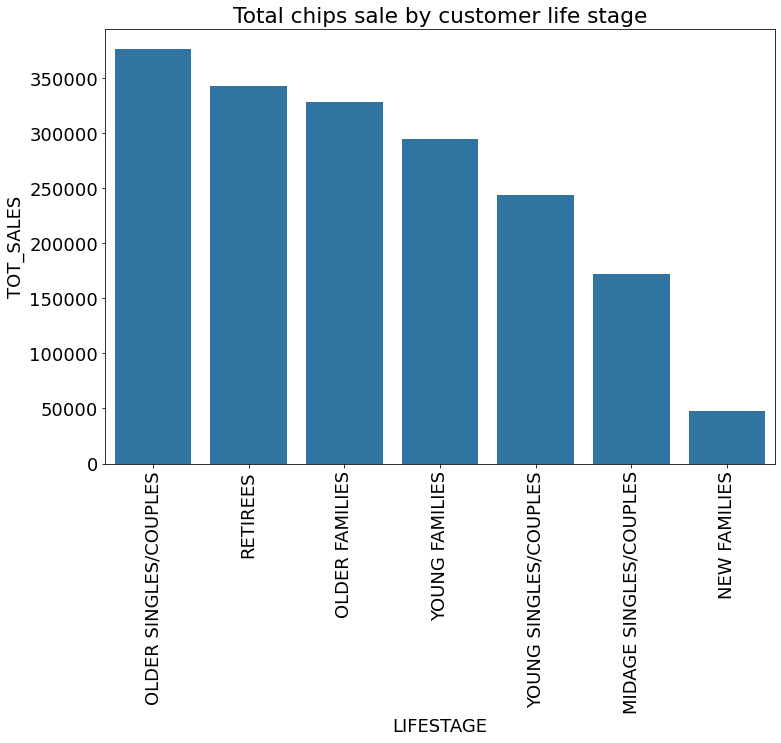

In [1776]:
life_stage_spender = df.groupby(['LIFESTAGE'])['TOT_SALES'].sum().sort_values(ascending=False).reset_index()
display(life_stage_spender)

plt.figure(figsize=(12,8))
sb.barplot(x=life_stage_spender.LIFESTAGE,y=life_stage_spender.TOT_SALES,color=color)
plt.xticks(rotation=90);
plt.title('Total chips sale by customer life stage');

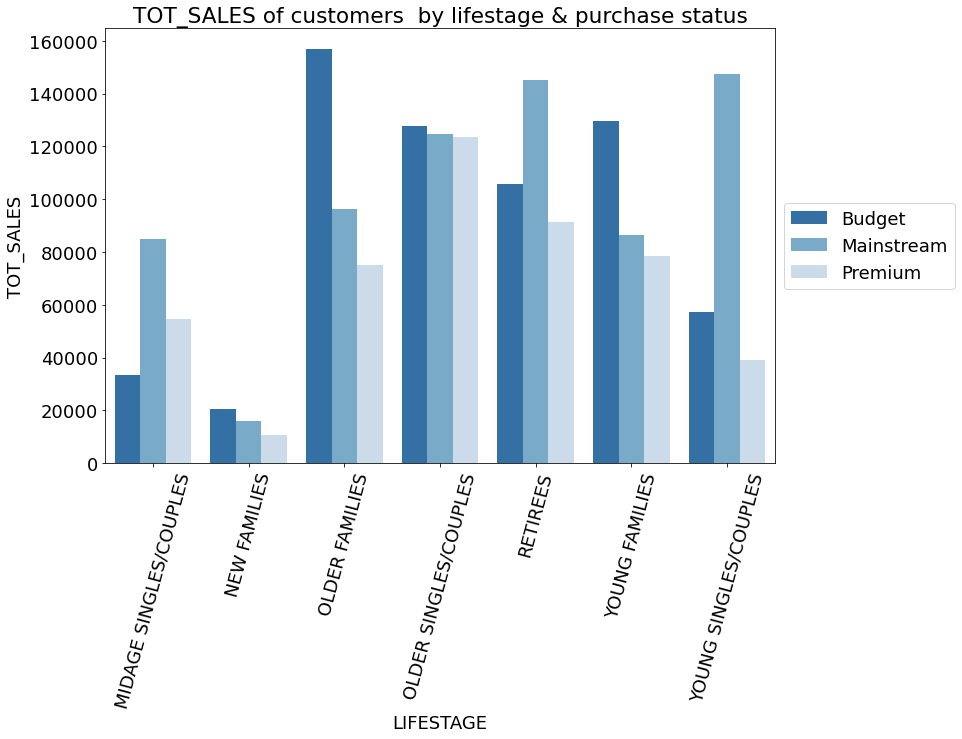

In [1777]:
premium_status = df.groupby(['LIFESTAGE','PREMIUM_CUSTOMER'])['TOT_SALES']\
                .sum().reset_index()
plt.figure(figsize=(12,8));
sb.barplot(x=premium_status.LIFESTAGE,y=premium_status.TOT_SALES,\
              hue=premium_status.PREMIUM_CUSTOMER,palette='Blues_r');
plt.xticks(rotation=75);
plt.legend(loc = 6, bbox_to_anchor = (1.0, 0.5)); 
plt.title('TOT_SALES of customers  by lifestage & purchase status');

Sales are coming mainly from Budget - older families, Mainstream - young, singles/couples and Mainstream -retirees

__How many customers are in each segment?__

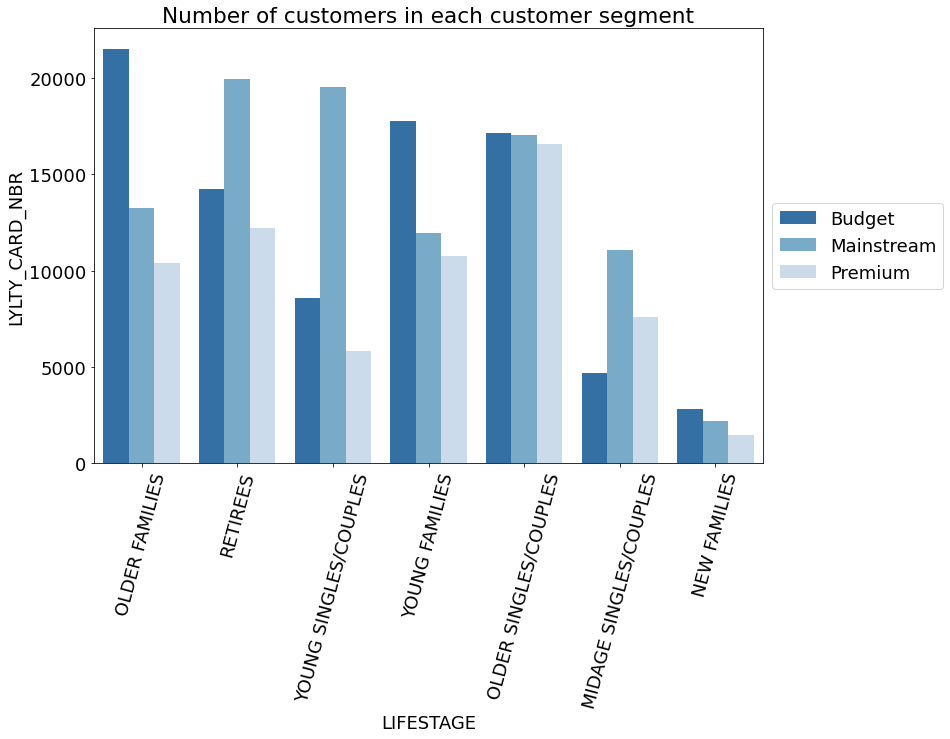

In [1778]:
customers = df.groupby(['LIFESTAGE','PREMIUM_CUSTOMER'])['LYLTY_CARD_NBR']\
                .count().sort_values(ascending=False).reset_index()
# display(customers)
plt.figure(figsize=(12,8))
sb.barplot(x=customers.LIFESTAGE,y=customers.LYLTY_CARD_NBR,\
       hue=customers.PREMIUM_CUSTOMER,palette='Blues_r');
plt.xticks(rotation=75);
plt.legend(loc = 6, bbox_to_anchor = (1.0, 0.5)); 
plt.title('Number of customers in each customer segment');

There are more Mainstream - young singles/couples and Mainstream - retirees who buy chips. This contributes to there being more sales to these customer segments but this is not a major driver for the Budget - Older families segment.
Higher sales may also be driven by more units of chips being bought per customer. Let's have a look at this next.


__What is the average # of chips bought per customer by segment?__

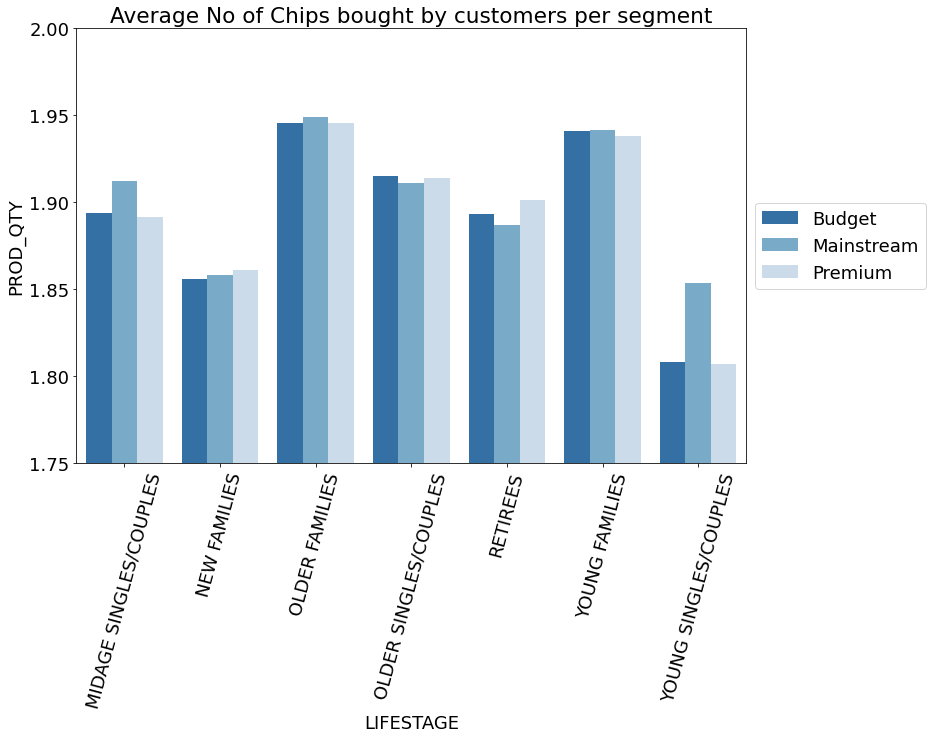

In [1779]:
premium_status_qty = df.groupby(['LIFESTAGE','PREMIUM_CUSTOMER'])['PROD_QTY']\
                .mean().reset_index()
# display(premium_status_qty)
plt.figure(figsize=(12,8));
sb.barplot(x=premium_status_qty.LIFESTAGE,y=premium_status_qty.PROD_QTY,\
              hue=premium_status_qty.PREMIUM_CUSTOMER,palette='Blues_r');
plt.xticks(rotation=75);
plt.ylim([1.75,2])
plt.legend(loc = 6, bbox_to_anchor = (1.0, 0.5)); 
plt.title('Average No of Chips bought by customers per segment');

Older families and young families in general buy more chips per customer

__Average price per unit by LIFESTAGE and PREMIUM_CUSTOMER__

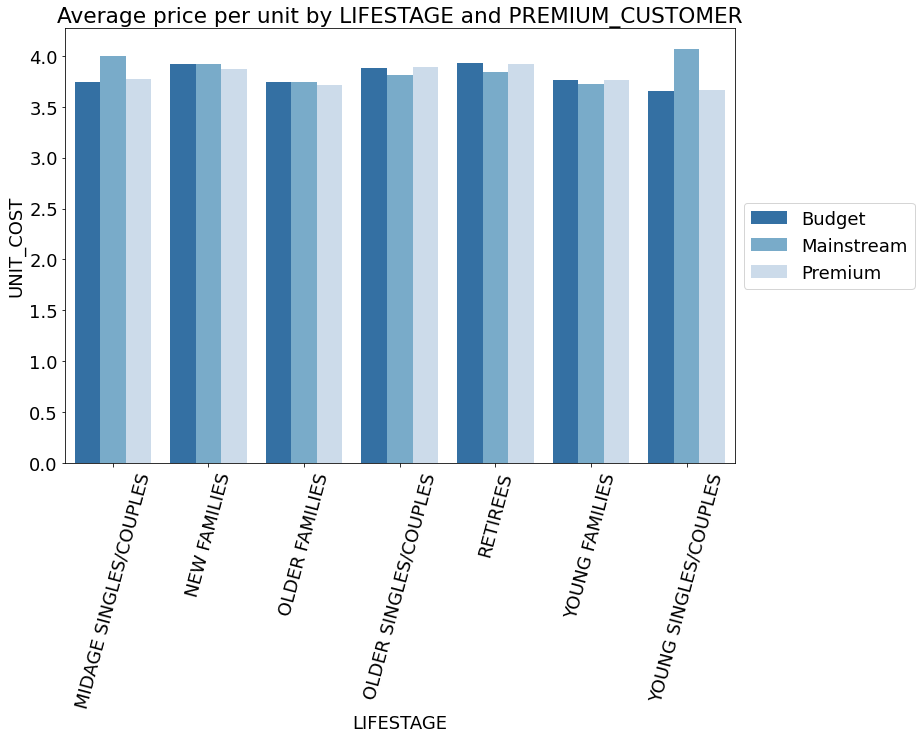

In [1780]:
premium_status_qty = df.groupby(['LIFESTAGE','PREMIUM_CUSTOMER'])['UNIT_COST']\
                .mean().reset_index()
# display(premium_status_qty)
plt.figure(figsize=(12,8));
sb.barplot(x=premium_status_qty.LIFESTAGE,y=premium_status_qty.UNIT_COST,\
              hue=premium_status_qty.PREMIUM_CUSTOMER,palette='Blues_r');
plt.xticks(rotation=75);
# plt.ylim([0.15,0.35])
plt.legend(loc = 6, bbox_to_anchor = (1.0, 0.5)); 
plt.title('Average price per unit by LIFESTAGE and PREMIUM_CUSTOMER');


__Mainstream midage__ and __young singles and couples__ are more willing to pay more per packet of chips compared to their budget and premium counterparts. This may be due to premium shoppers being more likely to buy healthy snacks, which cost a little more, and when they buy chips, this is mainly for entertainment purposes rather than their own consumption. This is also supported by there being fewer __premium midage__ and __young singles and couples__ buying chips compared to their mainstream counterparts.


Independent T-test between mainstream (of midrange and young singles) vs. premium and budget (of midrange and young)

In [1781]:
df.head()

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_SIZE,UNIT_COST,LIFESTAGE,PREMIUM_CUSTOMER,PROD_BRAND
0,2018-10-17,1,1000,1,5,Natural Chip Compny SeaSalt,2,6.0,175,3.00,YOUNG SINGLES/COUPLES,Premium,Natural
1,2019-05-14,1,1307,348,66,CCs Nacho Cheese,3,6.3,175,2.10,MIDAGE SINGLES/COUPLES,Budget,CCs
2,2019-05-20,1,1343,383,61,Smiths Crinkle Cut Chips Chicken,2,2.9,170,1.45,MIDAGE SINGLES/COUPLES,Budget,Smiths
3,2018-08-17,2,2373,974,69,Smiths Chip Thinly S/Cream & Onion,5,15.0,175,3.00,MIDAGE SINGLES/COUPLES,Budget,Smiths
4,2018-08-18,2,2426,1038,108,Kettle Tortilla ChpsHny & Jlpno Chili,3,13.8,150,4.60,MIDAGE SINGLES/COUPLES,Budget,Kettle


__Alternate hypothesis__:the unit price for mainstream, 
young and mid-age singles and couples __ARE__ significantly higher than that of budget or premium, young and midage singles and couples
    
__Null hypothesis__ : the unit price for mainstream, 
young and mid-age singles and couples __ARE NOT__  significantly higher than that of budget or premium, young and midage singles and couples

* if p-value < 0.01 then we reject the alternate hypothesis
* if p-value > 0.01 then we cannot alternate the null hypothesis 

In [1787]:
mainstream = df.query("LIFESTAGE == ['MIDAGE SINGLES/COUPLES','YOUNG SINGLES/COUPLES']")\
        .query("PREMIUM_CUSTOMER == 'Mainstream'")\
        .UNIT_COST
premium_budget = df.query("LIFESTAGE == ['MIDAGE SINGLES/COUPLES','YOUNG SINGLES/COUPLES']")\
        .query("PREMIUM_CUSTOMER == ['Budget','Premium']")\
        .UNIT_COST

In [1795]:
def ans(s,p):
        if p < 0.01:
            different = 'ARE'
            print('The t-test results in a p-value of {}, i.e. the unit price for mainstream, young and mid-age singles and couples {} significantly higher thanthat of budget or premium, young and midage singles and couples.'.format(p,different))
        else:
            different = 'ARE NOT'
            print('The t-test results in a p-value of {}, i.e. the unit price for mainstream,\ young and mid-age singles and couples {} significantly higher than that of budget or premium, young and midage singles and couples.'.format(p,different))      
        
s,p = ttest_ind(mainstream,premium_budget)

ans(s,p)

The t-test results in a p-value of 2.235645611549355e-309, i.e. the unit price for mainstream, young and mid-age singles and couples ARE significantly higher thanthat of budget or premium, young and midage singles and couples.


In [1820]:
mainstream = df.query("LIFESTAGE == ['MIDAGE SINGLES/COUPLES','YOUNG SINGLES/COUPLES']")\
             .query("PREMIUM_CUSTOMER == 'Mainstream'")
stats = pd.DataFrame(mainstream.PROD_BRAND.value_counts())
stats

,PROD_BRAND
Kettle,5980
Pringles,3474
Doritos,3148
Smiths,2966
Thins,1801
RRD Red,1486
Infuzions,1484
Twisties,1390
Tostitos,1369
Cobs,1359


In [1834]:
premium_budget = df.query("LIFESTAGE == ['MIDAGE SINGLES/COUPLES','YOUNG SINGLES/COUPLES']")\
        .query("PREMIUM_CUSTOMER == ['Budget','Premium']")
stats2 = pd.DataFrame(premium_budget.PROD_BRAND.value_counts())
stats2


,PROD_BRAND
Kettle,3968
Smiths,3112
Pringles,2599
Doritos,2153
RRD Red,2000
Thins,1474
WW,1441
Infuzions,1138
Cobs,998
Twisties,936


In [1839]:
print('It can be seen that the top 5 most prefered brands for mainstream MIDAGE SINGLES/COUPLES and YOUNG SINGLES/COUPLES  (in decreasing order) are: {}.While that for Budget,Premium are {}'\
    .format(stats.index[:5].values, stats2.index[:5].values))


It can be seen that the top 5 most prefered brands for mainstream MIDAGE SINGLES/COUPLES and YOUNG SINGLES/COUPLES  (in decreasing order) are: ['Kettle' 'Pringles' 'Doritos' 'Smiths' 'Thins'].While that for Budget,Premium are ['Kettle' 'Smiths' 'Pringles' 'Doritos' 'RRD Red']


Both customer segments have a preference for similar brands as their top 5 brands are almost the same.

In [1841]:
print('It can be seen that the top 5 least prefered brands for mainstream MIDAGE SINGLES/COUPLES and YOUNG SINGLES/COUPLES  (in decreasing order) are: {}.While that for Budget,Premium are {}.'\
    .format(stats.index[-5:].values, stats2.index[-5:].values))

It can be seen that the top 5 least prefered brands for mainstream MIDAGE SINGLES/COUPLES and YOUNG SINGLES/COUPLES  (in decreasing order) are: ['GrnWves' 'Burger' 'Snbts' 'Woolworths' 'Sunbites'].While that for Budget,Premium are ['Sunbites' 'Snbts' 'French' 'NCC' 'GrnWves'].


Therefore,it would be beneficial to increase stocks of Kettle, Pringles, Doritos, Smiths, Thins and RRD Red brands as they are most prefered by customer segments while reducing stock of GrnWves, Burger, Snbts, Woolworths, Sunbites, French, NCC.

In [1844]:
mainstream_sizes = mainstream.PACK_SIZE.value_counts()
mainstream_sizes

175    7972
150    4857
134    3474
110    3175
170    2457
330    1863
165    1743
270     963
380     936
210     883
135     453
250     427
200     311
190     264
160     229
90      197
180     118
70      113
220     110
125      94
Name: PACK_SIZE, dtype: int64

In [1845]:
premium_budget_size = premium_budget.STORE_NBR.value_counts().head(20)
premium_budget_size

247    197
153    192
165    189
23     182
94     172
201    171
175    170
217    168
57     167
55     166
128    165
157    164
95     164
236    160
164    158
110    157
79     156
7      156
65     156
237    154
Name: STORE_NBR, dtype: int64

In [1849]:
print('Additionlly, the top 5 most prefered sizes by mainstream MIDAGE SINGLES/COUPLES and YOUNG SINGLES/COUPLES  (in decreasing order) are: {}.While that for Budget,Premium are {}. The least frequented shop are {} and {} respectively'\
    .format(mainstream_sizes.index[:5].values, premium_budget_size.index[:5].values,mainstream_sizes.index[-5:].values, premium_budget_size.index[-5:].values ))

Additionlly, the top 5 most prefered sizes by mainstream MIDAGE SINGLES/COUPLES and YOUNG SINGLES/COUPLES  (in decreasing order) are: [175 150 134 110 170].While that for Budget,Premium are [247 153 165  23  94]. The least frequented shop are [ 90 180  70 220 125] and [110  79   7  65 237] respectively


Therefore, stock more of sizes 175 150 134 110 170 of the top 5 brands of mainstream MIDAGE SINGLES/COUPLES and YOUNG SINGLES/COUPLES. And for Budget and Premium products, stock more of sizes 247 153 165  23  94 as they could result in increase sales.

In [1812]:
df.STORE_NBR.value_counts().tail(20)

140    60
14     60
42     60
99     60
263    58
146    54
244    54
44     53
177    51
198    45
258    42
117    41
193     3
31      2
11      2
85      2
252     2
206     2
92      1
76      1
Name: STORE_NBR, dtype: int64

__How many chips are bought per customer by segment?__

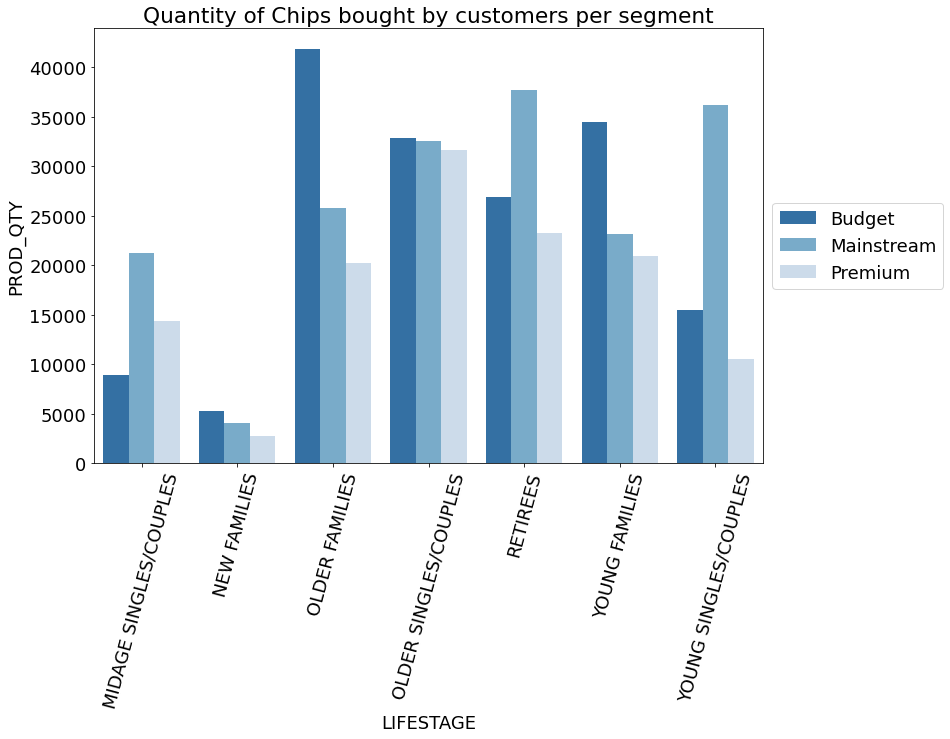

In [1689]:
premium_status_qty = df.groupby(['LIFESTAGE','PREMIUM_CUSTOMER'])['PROD_QTY']\
                .sum().reset_index()
# display(premium_status_qty)
plt.figure(figsize=(12,8));
sb.barplot(x=premium_status_qty.LIFESTAGE,y=premium_status_qty.PROD_QTY,\
              hue=premium_status_qty.PREMIUM_CUSTOMER,palette='Blues_r');
plt.xticks(rotation=75);
plt.legend(loc = 6, bbox_to_anchor = (1.0, 0.5)); 
plt.title('Quantity of Chips bought by customers per segment');

__What's the average chip price by customer segment?__

In [1691]:
avg_per_segment = df.groupby(['LIFESTAGE'])['TOT_SALES']\
                .mean().sort_values(ascending = False).reset_index()
avg_per_segment['REL_SALES'] = avg_per_segment.TOT_SALES/avg_per_segment.TOT_SALES[0]
avg_per_segment


,LIFESTAGE,TOT_SALES,REL_SALES
0,OLDER SINGLES/COUPLES,7.403009,1.000000
1,RETIREES,7.373994,0.996081
2,MIDAGE SINGLES/COUPLES,7.373442,0.996006
3,NEW FAMILIES,7.287664,0.984419
4,YOUNG FAMILIES,7.275841,0.982822
5,OLDER FAMILIES,7.274899,0.982695
6,YOUNG SINGLES/COUPLES,7.175854,0.969316


In [1661]:
# sb.barplot(x= avg_per_segment.LIFESTAGE,y=avg_per_segment.REL_SALES);
# plt.xticks(rotation=90);

## Strategy & Conclusions
<a id="conclusion"></a>